# MCMC and market Data



Our sales department is interested in a summary of the collected data. Please generate a report including numbers and diagrams. Note that your audience are not data scientists, so take care to prepare insights that are as clear as possible. We are interested in the following:

- Calculate the total number of customers in each section

- Calculate the total number of customers in each section over time

- Display the number of customers at checkout over time

- Calculate the time each customer spent in the market

- Calculate the total number of customers in the supermarket over time.

- Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

- start by analyzing a single file

- each day, the customer IDs start again at 1. These are different customers anyway.

- when the shop closes, the remaining customers are rushed through the checkout. Their checkout is not recorded, so it may look as if they stay in the market forever.

In [2]:
import pandas as pd
import numpy as np
import random as rm
import seaborn as sns
import matplotlib.pyplot as plt

# Import the Data and do feature engineering

In [3]:
#get the data and set the timestamp as index
friday=pd.read_table('friday.csv',sep=';',parse_dates=True, index_col="timestamp")
monday=pd.read_table('monday.csv',sep=';',parse_dates=True, index_col="timestamp")
thursday=pd.read_table('thursday.csv', sep=';',parse_dates=True, index_col="timestamp")
tuesday=pd.read_table('tuesday.csv',sep=';',parse_dates=True, index_col="timestamp")
wednesday=pd.read_table('wednesday.csv',sep=';',parse_dates=True, index_col="timestamp")

In [4]:
#concatenate the dataframes 
market=pd.concat([monday,tuesday,wednesday,wednesday,thursday,friday])

In [5]:
#sort the dataframe according to time index
market.sort_index(inplace=True)#to start from monday to friday and according to hours and minutes

In [6]:
#make different time indexes for time (h;m) and name of the day
market["time"] = market.index.time
market["day"] = market.index.day_name()
market["hour"]=market.index.hour

In [7]:
#create a new index for the customer ID for transition steps
#extract the first two letters from each day name and make a new series
name=[]
for i in market["day"]:
    name.append(i[0:2])
#create a new id name for each customer
market['day2']=name
market["ID"] = market['day2'] + "-" + market["customer_no"].astype(str)

In [8]:
#now check the dataframe
market

,customer_no,location,time,day,hour,day2,ID
timestamp,,,,,,,
2019-09-02 07:03:00,1,dairy,07:03:00,Monday,7,Mo,Mo-1
2019-09-02 07:03:00,2,dairy,07:03:00,Monday,7,Mo,Mo-2
2019-09-02 07:04:00,3,dairy,07:04:00,Monday,7,Mo,Mo-3
2019-09-02 07:04:00,4,dairy,07:04:00,Monday,7,Mo,Mo-4
2019-09-02 07:04:00,5,spices,07:04:00,Monday,7,Mo,Mo-5
...,...,...,...,...,...,...,...
2019-09-06 21:50:00,1507,checkout,21:50:00,Friday,21,Fr,Fr-1507
2019-09-06 21:50:00,1509,drinks,21:50:00,Friday,21,Fr,Fr-1509
2019-09-06 21:50:00,1496,fruit,21:50:00,Friday,21,Fr,Fr-1496


**Create a time difference for each customer**

- make an Entrance time point using min()

In [38]:
#make an enter time point
#reset the index
enter=market.reset_index()
#make a new dataframe out of two columns grouped by customer ID
enter=enter[["timestamp", "ID", "day"]].groupby("ID").min()
#change the name of the column to enter
Enter=enter.rename(columns={"timestamp": "enter"})
#sort the dataframe according to enter time
Enter=Enter.sort_values('enter');

- make an Exit time point using max()

In [39]:
#make an exit time point
#reset the index
exit=market.reset_index()
#make a new dataframe out of two columns grouped by customer ID
exit=exit[["timestamp", "ID"]].groupby("ID").max()
#change the name of the column to exit
exit=exit.rename(columns={"timestamp": "exit"})
#sort the dataframe according to exit time
exit=exit.sort_values('exit')

- time spent in the supermarkt for each customer

In [88]:
from datetime import timedelta
#combine entrance and exit dataframe
time_spent = pd.concat([Enter, exit], axis=1)
#calculate the time difference between enterance and exit
time_spent["D-minute"] = (time_spent['exit']-time_spent['enter'])
time_spent["D-minute"] = time_spent["D-minute"]/np.timedelta64(1, 'm')
#sort the dataframe according to time of enterance
time_spent=time_spent.sort_values('enter')

In [89]:
time_spent

,enter,day,exit,D-minute
ID,,,,
Mo-1,2019-09-02 07:03:00,Monday,2019-09-02 07:05:00,2.0
Mo-2,2019-09-02 07:03:00,Monday,2019-09-02 07:06:00,3.0
Mo-4,2019-09-02 07:04:00,Monday,2019-09-02 07:08:00,4.0
Mo-3,2019-09-02 07:04:00,Monday,2019-09-02 07:06:00,2.0
Mo-5,2019-09-02 07:04:00,Monday,2019-09-02 07:05:00,1.0
...,...,...,...,...
Fr-1507,2019-09-06 21:48:00,Friday,2019-09-06 21:50:00,2.0
Fr-1505,2019-09-06 21:48:00,Friday,2019-09-06 21:49:00,1.0
Fr-1508,2019-09-06 21:48:00,Friday,2019-09-06 21:50:00,2.0


# Data Exploration

In [90]:
#have a look on the structure of the data and whether it has missing data 
market.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29927 entries, 2019-09-02 07:03:00 to 2019-09-06 21:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_no  29927 non-null  int64 
 1   location     29927 non-null  object
 2   time         29927 non-null  object
 3   day          29927 non-null  object
 4   hour         29927 non-null  int64 
 5   day2         29927 non-null  object
 6   ID           29927 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.8+ MB


**How much time your customers spend in average in your supermarket**

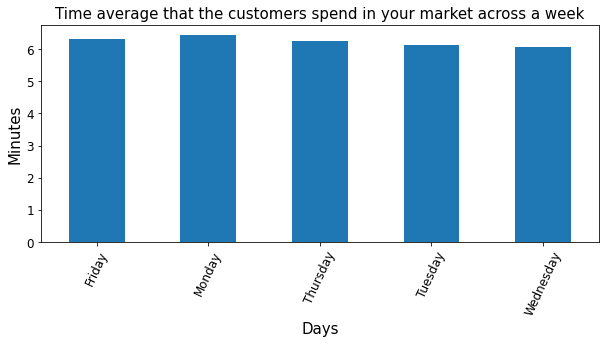

In [265]:
time_spent.groupby(["day"])["D-minute"].mean().plot(kind='bar',figsize=(10,4))
plt.title('Time average that the customers spend in your market across a week', fontsize=15)
plt.xlabel('Days',fontsize=15);plt.ylabel('Minutes',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=12);

**How much time your customers spend in average in your supermarket**

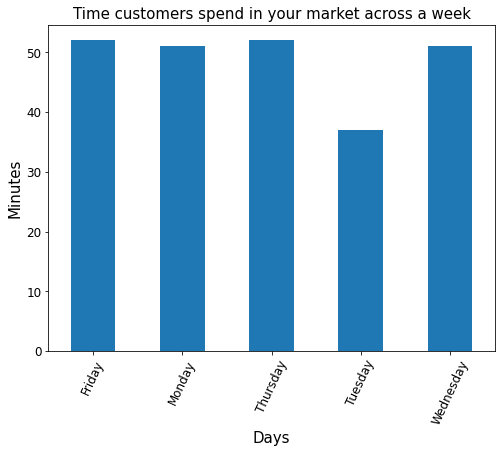

In [92]:
time_spent.groupby(["day"])["D-minute"].max().plot(kind='bar',figsize=(8,6))
plt.title('Time customers spend in your market across a week', fontsize=15)
plt.xlabel('Days',fontsize=15);plt.ylabel('Minutes',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=12);

**Calculate the total number of customers in each section**

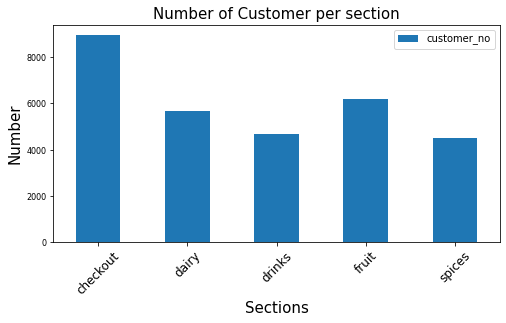

In [93]:
#make a plot for customer_section table
customer_section=market.pivot_table(index=['location'],aggfunc={'customer_no':'count'})
customer_section.plot(kind='bar',figsize=(8,4))
plt.title('Number of Customer per section', fontsize=15)
plt.xlabel('Sections',fontsize=15);plt.ylabel('Number',fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=8);

**Calculate the total number of customers in each section over time**

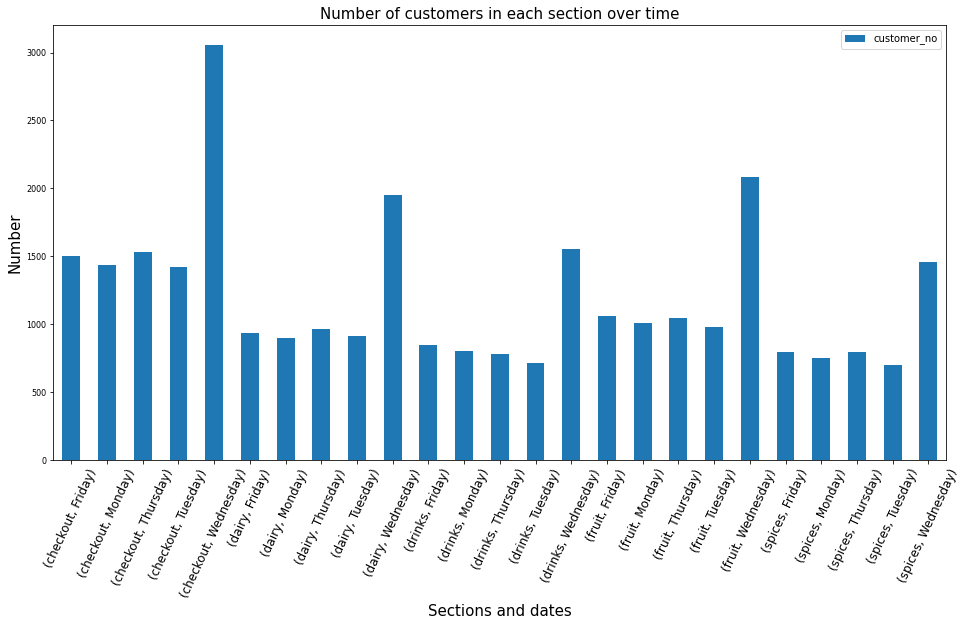

In [94]:
#make a table for total number of customers in each section over time
customer_sec_time=market.pivot_table(index=['location', 'day'],aggfunc={'customer_no':'count'})
customer_sec_time.plot(kind='bar', figsize=(16,8))
plt.title('Number of customers in each section over time', fontsize=15)
plt.xlabel('Sections and dates',fontsize=15);plt.ylabel('Number',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=8);

**Display the number of customers at checkout over time**

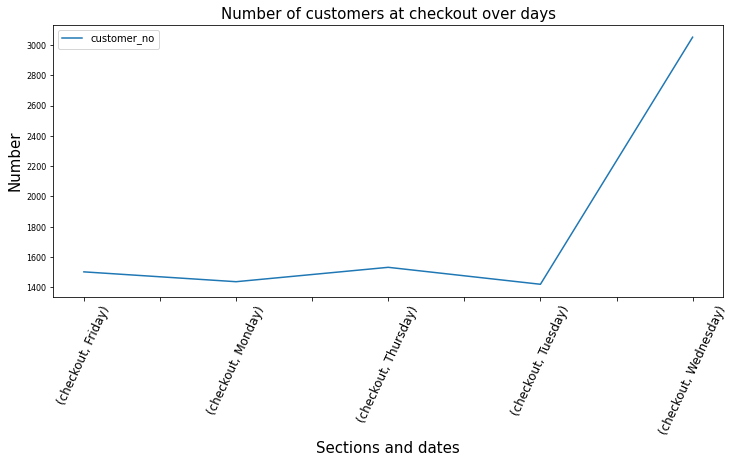

In [95]:
customer_checkout_day=market[market['location']=='checkout'].pivot_table(index=['location', 'day'],aggfunc={'customer_no':'count'})
customer_checkout_day.plot(kind='line', figsize=(12,5))
plt.title('Number of customers at checkout over days', fontsize=15)
plt.xlabel('Sections and dates',fontsize=15);plt.ylabel('Number',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=8);

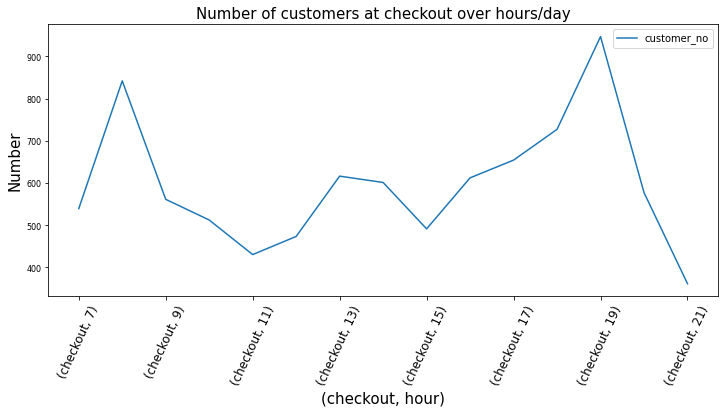

In [96]:
customer_checkout_hour=market[market['location']=='checkout'].pivot_table(index=['location', 'hour'],aggfunc={'customer_no':'count'})

customer_checkout_hour.plot(kind='line', figsize=(12,5))
plt.title('Number of customers at checkout over hours/day', fontsize=15)
plt.xlabel('(checkout, hour)',fontsize=15);plt.ylabel('Number',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=8);

**Calculate the total number of customers in the supermarket over time**

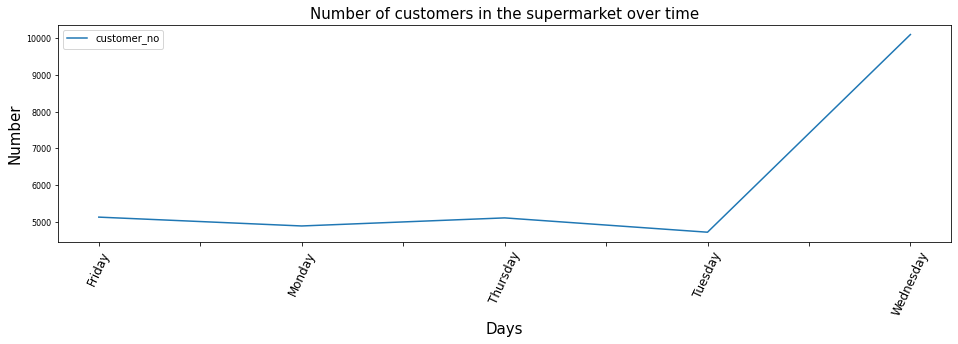

In [97]:
customer_supermarket_day=market.pivot_table(index=['day'],aggfunc={'customer_no':'count'})
customer_supermarket_day.plot(kind='line', figsize=(16,4))
plt.title('Number of customers in the supermarket over time', fontsize=15)
plt.xlabel('Days',fontsize=15);plt.ylabel('Number',fontsize=15)
plt.xticks(rotation=65,fontsize=12)
plt.yticks(fontsize=8);

**Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”)**

- Make a new colum called steps for first - followint - checkout entries

In [98]:
#prepare a series that has the ID and enterance time
enter=market.reset_index()[["timestamp", "ID"]].groupby("ID").min()
enter_TIME=enter.squeeze()#IMPORTANT:::: IT SHOULD BE A SERIES NOT A DATAFRAME

In [99]:
#1. make new column called steps with word :first: for first entry according to time index and ID 
for identity in market['ID'].unique():
    market.loc[(market['ID']==identity) & (market.index==enter_TIME[identity]), 'steps',]='first'

In [100]:
#market.loc[market["location"] == "checkout", "steps"] = "following"

In [101]:
#2. fill the NAs in the steps column with the word "following"
market["steps"].fillna("following", inplace=True)

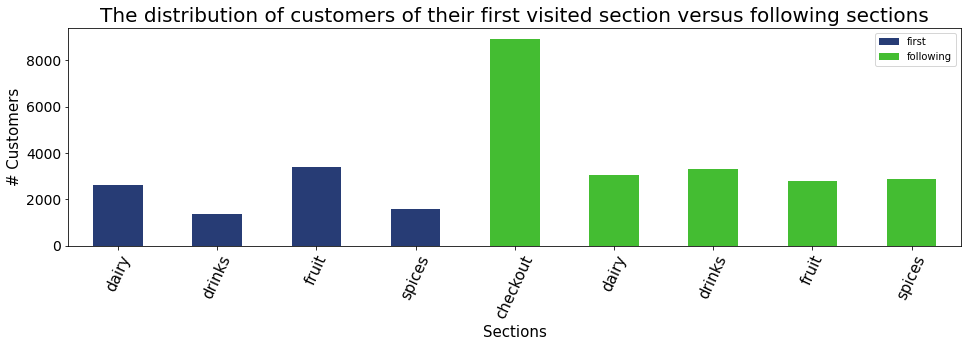

In [102]:
#make a table for the frequency and plot
distribution_first=market.pivot_table(index=['steps', 'location'],aggfunc={'customer_no':'count'})

from matplotlib.patches import Patch
colours = {"first": "#273c75", "following": "#44bd32"}
distribution_first.reset_index().plot(kind='bar', x='location', y='customer_no', 
                                      color=distribution_first.reset_index()['steps'].replace(colours),figsize=(16,4)).legend(
    [
        Patch(facecolor=colours['first']),
        Patch(facecolor=colours['following'])
    ], ["first", "following"]
)

plt.title('The distribution of customers of their first visited section versus following sections', fontsize=20)
plt.xlabel('Sections',fontsize=15);plt.ylabel('# Customers',fontsize=15)
plt.xticks(rotation=65,fontsize=15)
plt.yticks(fontsize=14);

**Estimate the total revenue for a customer using the following table**
- fruit 4€

- spices 3€

- dairy 5€

- drinks 6€

In [106]:
df=market

In [107]:
#create a new column and fill it with the corresponding values
df.loc[df['location']=='fruit', 'revenue']=4
df.loc[df['location']=='spices', 'revenue']=3
df.loc[df['location']=='dairy', 'revenue']=5
df.loc[df['location']=='drinks', 'revenue']=6
df.loc[df['location']=='checkout', 'revenue']=0

In [108]:
df.head(5)

,customer_no,location,time,day,hour,day2,ID,steps,revenue
timestamp,,,,,,,,,
2019-09-02 07:03:00,1,dairy,07:03:00,Monday,7,Mo,Mo-1,first,5.0
2019-09-02 07:03:00,2,dairy,07:03:00,Monday,7,Mo,Mo-2,first,5.0
2019-09-02 07:04:00,3,dairy,07:04:00,Monday,7,Mo,Mo-3,first,5.0
2019-09-02 07:04:00,4,dairy,07:04:00,Monday,7,Mo,Mo-4,first,5.0
2019-09-02 07:04:00,5,spices,07:04:00,Monday,7,Mo,Mo-5,first,3.0


In [109]:
#make a table to calculate the revenue for a specific customer
customer_revenue=df.pivot_table(index=['ID'],aggfunc={'revenue':np.sum}).reset_index()
customer_revenue.loc[customer_revenue['ID']== 'Fr-1001']

,ID,revenue
4,Fr-1001,23.0


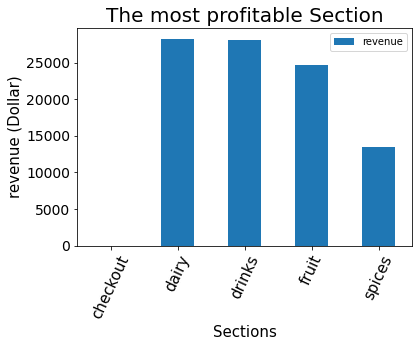

In [110]:
#make a table to calculate the revenue for a specific customer
most_revenue=df.pivot_table(index=['location'],aggfunc={'revenue':np.sum})
most_revenue.plot(kind='bar')
plt.title('The most profitable Section', fontsize=20)
plt.xlabel('Sections',fontsize=15);plt.ylabel('revenue (Dollar)',fontsize=15)
plt.xticks(rotation=65,fontsize=15)
plt.yticks(fontsize=14);

# Generate the transition matrix (mt)

In [111]:
# now sort your dataframe and chose only timestamp and customer ID
df=market.filter(['customer_no','ID', 'location']).reset_index().set_index("ID")

In [112]:
#remove customers that did not checkout
stay=df.groupby(['ID'])['location'].last()!='checkout'
stay

ID
Fr-1       False
Fr-10      False
Fr-100     False
Fr-1000    False
Fr-1001    False
           ...  
We-995     False
We-996     False
We-997     False
We-998     False
We-999     False
Name: location, Length: 7445, dtype: bool

In [113]:
#collect the customers that did not checkout
list_stay=[]
for index, value in stay.items():
    if value == True:
        list_stay.append(index)
print(len(list_stay))

28


In [114]:
#first five customers without checkout
list_stay

['Fr-1494',
 'Fr-1496',
 'Fr-1500',
 'Fr-1503',
 'Fr-1505',
 'Fr-1506',
 'Fr-1509',
 'Fr-1510',
 'Mo-1430',
 'Mo-1433',
 'Mo-1437',
 'Mo-1439',
 'Mo-1440',
 'Mo-1441',
 'Mo-1443',
 'Mo-1445',
 'Mo-1446',
 'Mo-1447',
 'Th-1527',
 'Th-1532',
 'Th-1533',
 'Tu-1411',
 'Tu-1422',
 'We-1520',
 'We-1527',
 'We-1528',
 'We-1529',
 'We-1530']

In [115]:
#reset the index to drop all those customers
df_clean=df.drop(list_stay, axis=0)

In [116]:
#sort the values according to customer number and time index
df_clean=df_clean.sort_values(["customer_no", "timestamp"])

In [117]:
#make the new column for the shift and call it next
df_clean["next"] = df_clean["location"].shift(-1)

**The transition that I need to have in order to make the probabilities correct**
- dairy  > checkout
- fruites>drinks
- drinks>checkout
- fruits>fruits
- fruits>checkout
- checkout > checkout

**Accordingly, we have to remove all checkouts from location to avoid this:**

- checkout > fruit

In [147]:
df_clean.dropna(inplace=True)

In [148]:
data=df_clean.sort_values('ID') 

In [149]:
#make crosstable for probabilities
P= pd.crosstab(data["location"], data["next"], normalize=0)

In [150]:
#check the table (((from MARTA)))
P.loc['checkout']=(1,0,0,0,0)

In [151]:
P

next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.324618,0.172714,0.183920,0.157062,0.161686
drinks,0.449592,0.022737,0.165809,0.181682,0.180180
fruit,0.415988,0.196841,0.113318,0.169326,0.104526
spices,0.210750,0.270997,0.228443,0.127212,0.162598


In [152]:
P2=P.drop('checkout').reset_index().drop('checkout', axis=1).set_index('location')

In [153]:
P2.values

array([[0.17271434, 0.18392031, 0.15706154, 0.16168623],
       [0.02273702, 0.16580867, 0.18168168, 0.18018018],
       [0.19684142, 0.11331814, 0.16932595, 0.10452621],
       [0.27099664, 0.22844345, 0.12721165, 0.16259798]])

In [154]:
states2=P2.columns

In [155]:
states2

Index(['dairy', 'drinks', 'fruit', 'spices'], dtype='object', name='next')

In [156]:
#check if sum of all rows is equal to one
P.sum(axis=1)

location
checkout    1.0
dairy       1.0
drinks      1.0
fruit       1.0
spices      1.0
dtype: float64

In [157]:
#an array 
transition_matrix=P.values

In [158]:
transition_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.32461757, 0.17271434, 0.18392031, 0.15706154, 0.16168623],
       [0.44959245, 0.02273702, 0.16580867, 0.18168168, 0.18018018],
       [0.41598828, 0.19684142, 0.11331814, 0.16932595, 0.10452621],
       [0.21075028, 0.27099664, 0.22844345, 0.12721165, 0.16259798]])

In [159]:
P[P.index == 'dairy'].values[0]

array([0.32461757, 0.17271434, 0.18392031, 0.15706154, 0.16168623])

In [160]:
states=P.columns

In [161]:
states

Index(['checkout', 'dairy', 'drinks', 'fruit', 'spices'], dtype='object', name='next')

http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

# Plot transition inside the market

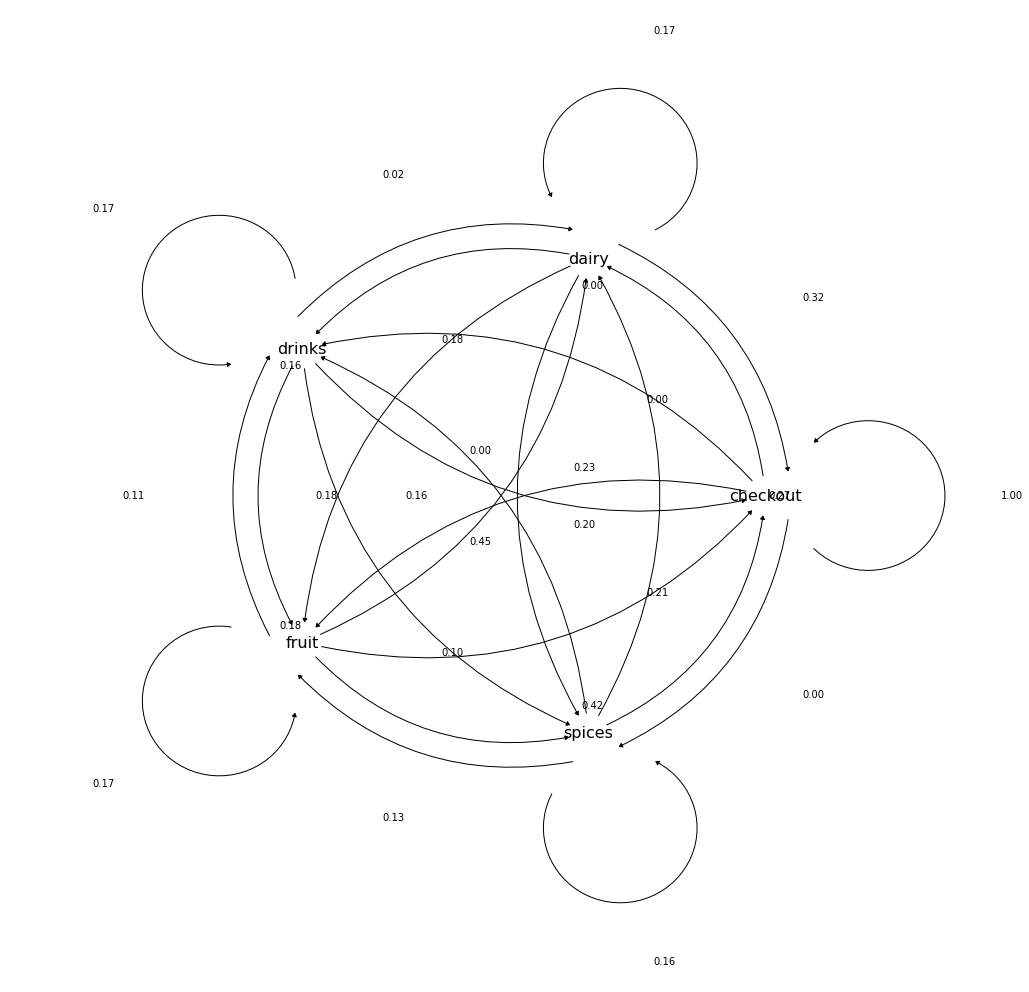

In [257]:
from hmmviz import TransGraph
graph = TransGraph(P)
# looks best on square figures/axes
fig = plt.figure(figsize=(18, 18))
graph.draw(edgelabels=True,edgewidths=1,nodefontsize=16)

**Suggestions for better graphs**
- Networkx library
https://networkx.org/documentation/stable/auto_examples/basic/plot_simple_graph.html
- Graphviz and pygraphviz 
https://pygraphviz.github.io/documentation/stable/install.html#recommended

**As Example:**

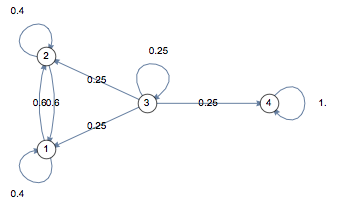

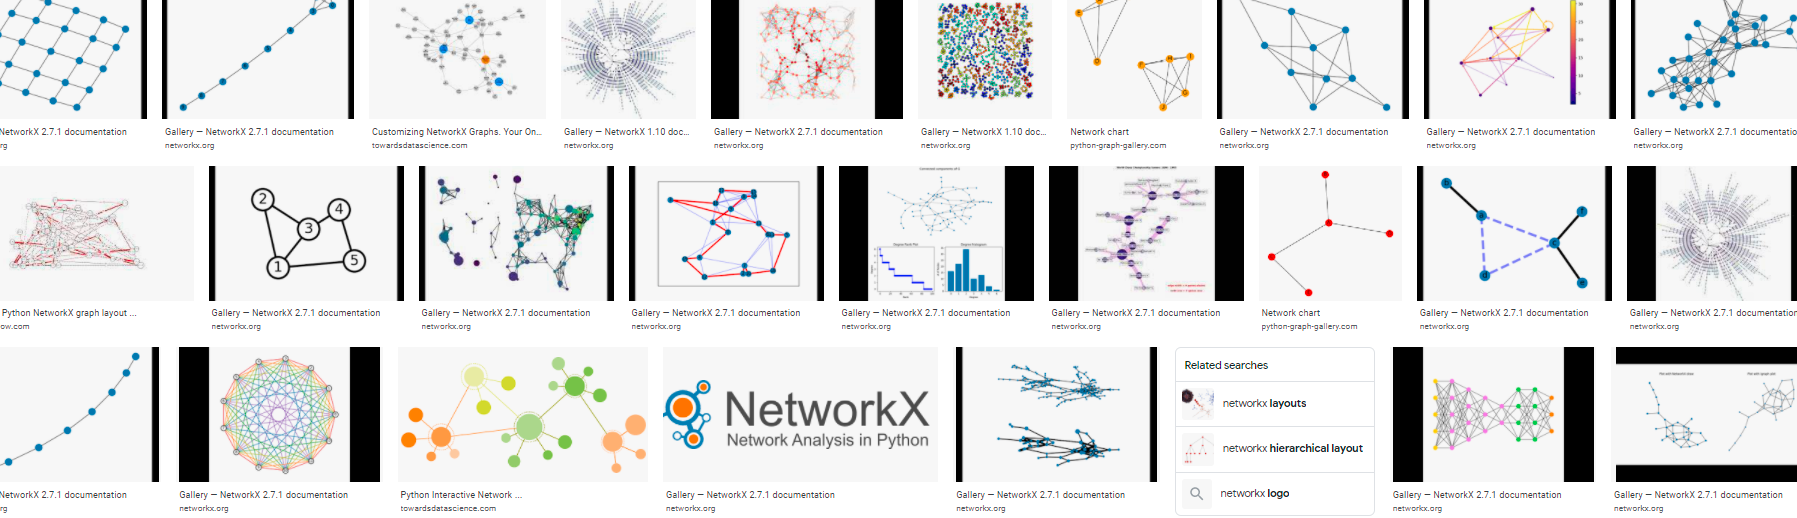

# Make prediction

In [163]:
#predict the next step for a customer based on his current location
from random import choices
def predict(state):
    return choices(states, weights = P[P.index == state].values[0])

In [259]:
#check the function
predict('fruit')

['drinks']

In [263]:
#predict multiple steps
for i in states:
    if i == 'checkout':
        print('he/she left early')
    else:
        print(f'if the customer was in {i}, he/she might move next to {predict(i)}')
    

he/she left early
if the customer was in dairy, he/she might move next to ['checkout']
if the customer was in drinks, he/she might move next to ['drinks']
if the customer was in fruit, he/she might move next to ['drinks']
if the customer was in spices, he/she might move next to ['fruit']


# MCMC simulation

In [176]:
from faker import Faker

In [254]:
#create a class customer
f=Faker()
class Customer:
    """Simulation for customer steps.Movements:
    state= The current location of the customer.
    name: fake first name (generated by Faker)
    """ 
    def __init__(self):
        self.name=f.name()
        self.state =np.random.choice(['dairy', 'drinks', 'fruit', 'spices'], 1, p=[0.25,0.25,0.25,0.25])
        
    def __repr__(self):
        return f"""{self.name} was in section '{self.state}'"""

    def predict(self):
        self.state = choices(['checkout','dairy', 'drinks', 'fruit', 'spices'], weights = P[P.index == ['checkout','dairy', 'drinks', 'fruit', 'spices']].values[0])
        return self.state       

In [255]:
for i in range(0,10):
    customer = Customer()
    print(customer)
    customer.predict()
    print(f'then he moved to {customer.predict()}')

Randy Nixon Jr. was in section '['dairy']'
then he moved to ['checkout']
Kevin Robinson was in section '['dairy']'
then he moved to ['checkout']
Clayton Davis was in section '['dairy']'
then he moved to ['checkout']
Meredith Gutierrez was in section '['spices']'
then he moved to ['checkout']
Nathan Moses was in section '['fruit']'
then he moved to ['checkout']
Charles Davis was in section '['drinks']'
then he moved to ['checkout']
Christina Bryant was in section '['dairy']'
then he moved to ['checkout']
Brenda Coffey was in section '['drinks']'
then he moved to ['checkout']
Ashley Hodge was in section '['dairy']'
then he moved to ['checkout']
Stephanie Hill was in section '['drinks']'
then he moved to ['checkout']


**My customers are all from England and they were not satisfied, they were running to chekcout**

# Progress assessment
- BIG THANKS TO MARTA ... AND... BRUNU
- learning how to extract the transition matrix for MC
- learning new functions in pandas
- learning new aspect of MC
- the whole week was a training on how to insert delete entries row wise 
- learning more about numpy
# hiccups 
- I had no time to develop customer class but I did understand the concept
- I had difficulties to find a good library to draw a nice diagram for Markov Chain transition matrix